# Figure 2, nucleotide diversity

In [1]:
%run ../../shared_setup.ipynb

docker image cggh/biipy:v1.6.0


In [2]:
# load SNPs for all three crosses
callsets = load_callsets(COMBINED_CALLSET_FN_TEMPLATE, 
                         variant_filter='FILTER_PASS & is_snp')

2016-03-08 18:08:58.645723 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.combined.final.npz
2016-03-08 18:08:58.920995 :: filter variants: excluding 26856 (63.6%) retaining 15388 (36.4%) of 42244 variants
2016-03-08 18:08:58.929189 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/hb3_dd2.combined.final.npz
2016-03-08 18:08:59.284050 :: filter variants: excluding 22026 (59.7%) retaining 14885 (40.3%) of 36911 variants
2016-03-08 18:08:59.294044 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/7g8_gb4.combined.final.npz
2016-03-08 18:08:59.663175 :: filter variants: excluding 20383 (58.6%) retaining 14392 (41.4%) of 34775 variants


In [3]:
palette = sns.color_palette()
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [4]:
def plot_genome_diversity_linear(ax, window_size=5e2, limy=(0, .1)):
    offset = 0
    
    for i, chrom in enumerate(CHROMOSOMES):
    
        # plot windowed SNP density
#         colors = sns.color_palette()
        colors = 'rgb'
        for cross, color in zip(CROSSES, colors):
            variants = callsets[cross]['variants']
            # SNPs in given CHROM only
            variants = variants[variants.CHROM == chrom]
            pos = variants.POS
            pos_bins = np.arange(0, len(fasta[str(chrom, 'ascii')]), window_size)
            pos_hist, _ = np.histogram(pos, bins=pos_bins)
            x1 = pos_bins[:-1] + (window_size/2)
            y1 = pos_hist / window_size
            pos_bins = pos_bins + window_size/2
            pos_hist, _ = np.histogram(pos, bins=pos_bins)
            x2 = pos_bins[:-1] + (window_size/2)
            y2 = pos_hist / window_size
            x = interleave(x1, x2) + offset
            y = interleave(y1, y2)
            ax.plot(x, y, 
                    alpha=1, 
                    color=color,
                    markerfacecolor='w',
                    linewidth=.5,
                    linestyle=' ', 
                    marker='o', 
                    markeredgewidth=.5, 
                    markeredgecolor=color,
                    markersize=3, 
                    label=LABELS[cross])
            
        # plot chromosome boundary
        ax.plot([offset, offset], limy, linestyle=':', color='k')
        
        offset += len(fasta[str(chrom, 'ascii')])
            
    # tidy up
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    ax.xaxis.tick_bottom()
    ax.set_xticks([])
#     ax.set_ylim(*limy)
    
    xt = list()
    cs = [len(fasta[str(c, 'ascii')]) for c in CHROMOSOMES]
    for i, s in enumerate(cs):
        v = s/2 + sum(cs[:i])
        xt.append(v)
    ax.xaxis.tick_top()
    ax.set_xticks(xt)
    ax.set_xticklabels(range(1, 15))
    ax.set_ylabel(r'$\pi$', rotation=0, fontsize=10)
    # ax.set_ylabel('nucleotide diversity')
    ax.set_xlim(0, sum(cs))
    ax.yaxis.tick_left()
    
    return ax
    

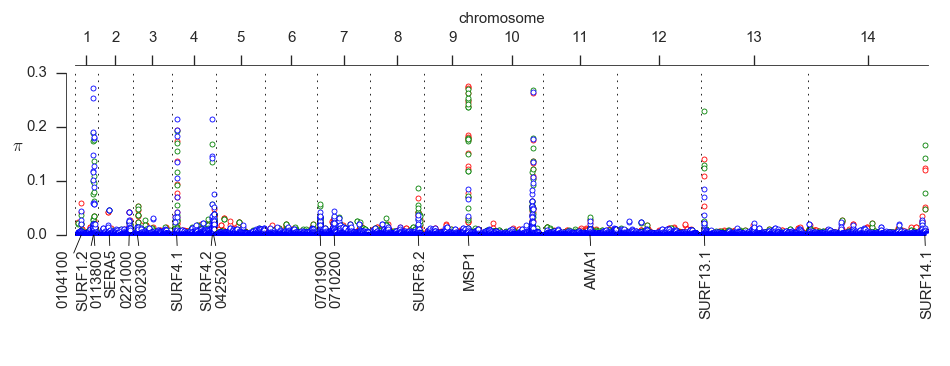

In [5]:
fig = plt.figure(figsize=(8, 3))
gs = GridSpec(2, 1, height_ratios=[3, 1])

# spacer
ax = fig.add_subplot(gs[1])
ax.set_axis_off()

ax = fig.add_subplot(gs[0])
plot_genome_diversity_linear(ax, limy=(0, .3))
# annotate divergent genes
annotations = [('PF3D7_0104100', -15),
               ('PF3D7_0113600', -10),
               ('PF3D7_0113800', -2),
               ('PF3D7_0207600', -3),
               ('PF3D7_0221000', -5),
               ('PF3D7_0302300', -1),
               ('PF3D7_0402200', -3),
               ('PF3D7_0424400', -7),
               ('PF3D7_0425200', 1),
               ('PF3D7_0701900', -3),
               ('PF3D7_0710200', -3),
               ('PF3D7_0830800', -3),
               ('PF3D7_0930300', -3),
#               ('PF3D7_1035400', -3),
#               ('PF3D7_1035500', -3),
#               ('PF3D7_1035700', -3),
#               ('PF3D7_1036300', -3),
               ('PF3D7_1133400', -3),
               ('PF3D7_1301800', -3),
               ('PF3D7_1477600', -3)]
chrsizes = [len(fasta[str(chrom, 'ascii')]) for chrom in CHROMOSOMES]
for a, xof in annotations:
    f = lkp_feature[a]
    chridx = CHROMOSOMES.index(f['feature_chrom'].encode('ascii'))
    x = sum(chrsizes[:chridx]) + f['feature_start']
    lbl = f['feature_name'] if f['feature_name'] is not None else f['feature_id'][6:]
    ax.annotate(lbl, 
                xy=(x, 0), 
                xytext=(xof, -15), 
                xycoords='data', 
                textcoords='offset points', 
                rotation=90, 
                arrowprops=dict(arrowstyle='-',
                                connectionstyle='arc3',
                                shrinkA=0, shrinkB=0),
                )
ax.set_xlabel('chromosome')
ax.xaxis.set_label_position('top')
ax.set_yticks(np.arange(0, .4, .1))

fig.tight_layout()
fig.subplots_adjust(bottom=.1)
fig.savefig('../../artwork/main/fig2A.jpeg', dpi=900, jpeg_quality=100);

In [6]:
def plot_local_diversity(ax, chrom, start=None, stop=None, window_size=5e2):
    # setup
    if start is None:
        start = 0
    if stop is None:
        stop = CHRSIZE[chrom]
    
    # plot windowed SNP density
    for cross, color in zip(CROSSES, 'rgb'):
        variants = callsets[cross]['variants']
        # SNPs in given CHROM only
        variants = variants[variants.CHROM == chrom]
        pos = variants['POS']
        pos_bins = np.arange(start, stop, window_size)
        pos_hist, _ = np.histogram(pos, bins=pos_bins)
        x1 = pos_bins[:-1] + (window_size/2)
        y1 = pos_hist * 1. / window_size
        # nonoverlapping
        #X, Y = X1, Y1
        # half-overlapping
        pos_bins = pos_bins + window_size/2
        pos_hist, _ = np.histogram(pos, bins=pos_bins)
        x2 = pos_bins[:-1] + (window_size/2)
        y2 = pos_hist * 1. / window_size
        x = interleave(x1, x2)
        y = interleave(y1, y2)
        ax.plot(x, y, 
                alpha=1, 
                linestyle='-', 
                linewidth=.5,
                color=color,
                markeredgecolor=color,
                markerfacecolor='w', 
                marker='o', 
                markeredgewidth=.5, 
                markersize=3, 
                label=LABELS[cross])
    ax.set_xlim(start, stop)
    ax.set_xticks([])
    ax.set_ylabel(r'$\pi$', rotation=0, fontsize=10)
#     ax.set_ylabel('nucleotide diversity')
    for s in 'top', 'bottom', 'right':
        ax.spines[s].set_visible(False)
    ax.yaxis.tick_left()
    
    # tidy up
    sns.despine(ax=ax, bottom=True, offset=5)
#    ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    artists = [Rectangle((0, 0), 1, 1, fc=c, alpha=.7) for c in 'rgb']
#    labels = [LABELS[c] for c in CROSSES]
#    ax.legend(artists, labels, loc='upper left', fontsize=14, numpoints=1)


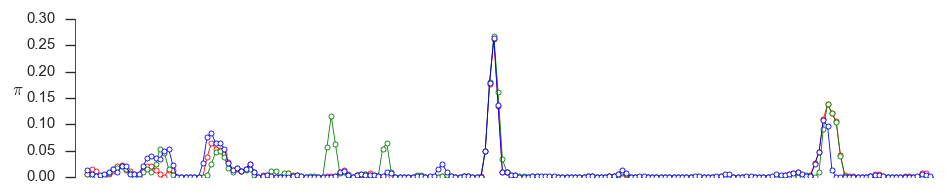

In [7]:
fig = plt.figure(figsize=(8, 1.7))
ax = fig.add_subplot(111)
plot_local_diversity(ax, b'Pf3D7_10_v3', start=1390000, stop=1440000)
fig.tight_layout()

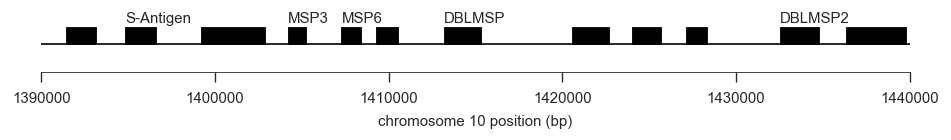

In [8]:
fig = plt.figure(figsize=(8, 1.2))
ax = fig.add_subplot(111)
annotate_genes = ['PF3D7_1035200', 'PF3D7_1035400', 'PF3D7_1035500', 'PF3D7_1035700', 'PF3D7_1036300']
gene_labels = {'PF3D7_1035200': 'S-Antigen', 'PF3D7_1035700': 'DBLMSP', 'PF3D7_1036300': 'DBLMSP2'}
annotate_bbox = dict()
annotate_arrowprops = dict()
plot_genes(ax, 'Pf3D7_10_v3', start=1390000, stop=1440000, annotate_genes=annotate_genes, gene_labels=gene_labels, annotate_xtext=0,
           annotate_ytext_fwd=13, annotate_bbox=annotate_bbox, annotate_arrowprops=annotate_arrowprops)
ax.set_xlabel('chromosome 10 position (bp)')
fig.tight_layout()
# ax.set_ylabel('genes', rotation=0, ha='right');


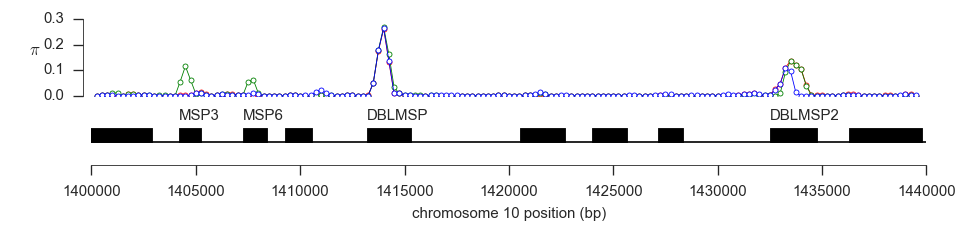

In [9]:
chrom, start, stop = b'Pf3D7_10_v3', 1400000, 1440000

fig = plt.figure(figsize=(8, 2))
gs = GridSpec(2, 1, height_ratios=[3, 1.8])

ax = fig.add_subplot(gs[0])
plot_local_diversity(ax, chrom, start=start, stop=stop)
ax.set_yticks(np.arange(0, .4, .1))

ax = fig.add_subplot(gs[1])
annotate_genes = ['PF3D7_1035200', 'PF3D7_1035400', 'PF3D7_1035500', 'PF3D7_1035700', 'PF3D7_1036300']
gene_labels = {'PF3D7_1035200': 'S-Antigen', 'PF3D7_1035700': 'DBLMSP', 'PF3D7_1036300': 'DBLMSP2'}
annotate_bbox = dict()
annotate_arrowprops = dict()
plot_genes(ax, str(chrom, 'ascii'), start=start, stop=stop, annotate_genes=annotate_genes, gene_labels=gene_labels, annotate_xtext=0,
           annotate_ytext_fwd=13, annotate_bbox=annotate_bbox, annotate_arrowprops=annotate_arrowprops)
ax.set_xlabel('chromosome 10 position (bp)')
# ax.set_ylabel('genes', rotation=0, ha='right')

fig.tight_layout()
fig.savefig('../../artwork/main/fig2B.jpeg', dpi=900, jpeg_quality=100);

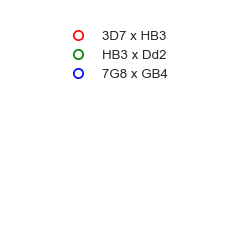

In [10]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_axis_off()
artists = [plt.Line2D((0, 0), (1, 1), linestyle=' ', marker='o', mew=1, mec=c, mfc='w') for c in 'rgb']
labels = [LABELS[c] for c in CROSSES]
ax.legend(artists, labels, loc='upper left', bbox_to_anchor=(0, 1), numpoints=1, fontsize=8, frameon=False, framealpha=.5);
fig.tight_layout()
fig.savefig('../../artwork/main/fig2_legend.jpeg', dpi=900, jpeg_quality=100)

In [11]:
8 * 2.54

20.32

In [12]:
5 * 2.54

12.7